# Sentiment Tree

[link](https://nlp.stanford.edu/sentiment/)

## Recursive neural network

Ostatnim typem sieci, które poznamy są <b>Rekursywne sieci neuronowe</b> (<i>Recursive neural networks</i>). Pozwalają one na predykcję i generowanie nowych informacji na podstawie ustrukturyzowanych danych (np. wypowiedzi w języku naturalnym) albo obrazów.


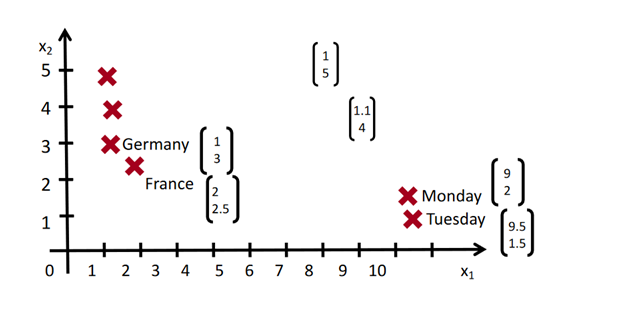


Punktem wyjścia w ich przypadku jest <b>analiza składniowa</b> (<i>parsing</i>) - jedno z narzędzi lingwistycznych pozwalających badać strukturę gramatyczną i treść dowolnego ciągu znaków. Polega ona na badaniu:
- znaczenia słów
- reguł łączących je w całość

Jednym z najpowszechniej sposób reprezentowania języka w ramach analizy składniowej są <b>drzewa wyprowadzenia</b> (<i>parse trees</i>):

[![](https://upload.wikimedia.org/wikipedia/commons/6/6e/ParseTree.svg)](https://en.wikipedia.org/wiki/Parse_tree)

Sieci rekursywne wykorzystują właśnie drzewa wyprowadzenia do przetwarzania języka naturalnego (ale też obrazów i dowolnych innych ustrukturyzowanych danych). Każdy pojedynczy symbol (jedno słowo, jeden fragment rysunku, etc.) jest reprezentowany przez wektor wartości liczbowych $c_i$ długości $n$.

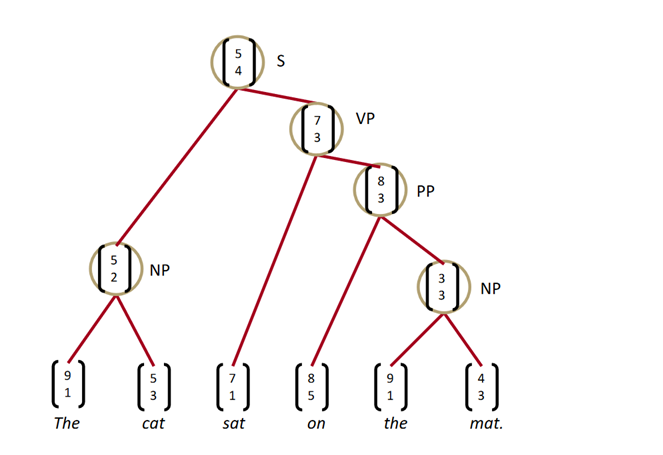

Każdy węzeł nadrzędny jest złożeniem dwóch węzłów $c_i$ i $c_j$ postaci: 

$p_{ij} = tanh(W [{c_i \atop c_j}] +b)$,

gdzie $tanh$ to tangens hiperboliczny służący wprowadzeniu do modelu nieliniowości (można wykorzystać inne funkcje), a $W$ to macierz wag $n \times 2n$, który jest taki sam dla każdej pary węzłów w sieci. Wartość $p_{ij}$ służy do wyznacznia jakości połączenia pomiędzy węzłami:

$$s_n = U^Tp_{ij}$$

gdzie $U$ to wartość wyznaczona dla przodka obu węzłów.

[![](https://upload.wikimedia.org/wikipedia/commons/6/60/Simple_recursive_neural_network.svg)](https://en.wikipedia.org/wiki/Recursive_neural_network)

Optymalizując rekursywną sieć neuronową staramy się osiągnąć możliwie jak najwyższą trafność na całym drzewie:

$$s(x,y) = \sum_{n \in ||N||} s_n(x,y)$$

gdzie $x$ to reprezentacja obiektu (wyrażenia) a $y$ drzewo parsowania.

Funkcja straty przyjmuje postać:

$$J = \sum_i (s(x_i,y_i) - \max_{y \in A(x_i)} (s(x_i,y) + L(y,y_i)))$$

gdzie $A(x)$ to przestrzeń wszystkich dopuszczalnych drzew dla sentencji $x$, a $ L(y,y_i)$ strata (entropia) na wybranej strukturze drzewa.

In [61]:
using Flux
using Flux: onehot,onecold
using Flux.Data.Sentiment
using Flux.Data: Tree, leaves
using BSON, Statistics

In [2]:
traintrees = Sentiment.train();

In [66]:
# Get the raw labels and phrases as separate trees.
labels  = map.(x -> x[1], traintrees);
phrases = map.(x -> x[2], traintrees);

In [91]:
# All tokens in the training set.
tokens = vcat(map(leaves, phrases)...)

# Count how many times each token appears.
freqs = Dict{String,Int}()
for t in tokens
  freqs[t] = get(freqs, t, 0) + 1
end

# Replace singleton tokens with an "unknown" marker.
# This roughly cuts our "alphabet" of tokens in half.
phrases = map.(t -> get(freqs, t, 0) == 1 ? "UNK" : t, phrases)

# Our alphabet of tokens.
alphabet = unique(vcat(map(leaves, phrases)...))

# One-hot-encode our training data with respect to the alphabet.
phrases_e = map.(t -> t == nothing ? t : onehot(t, alphabet), phrases)
labels_e  = map.(t -> onehot(t, 0:4), labels)

train = map.(tuple, phrases_e, labels_e);

In [96]:
testtrees = Sentiment.test();
labels_test  = map.(x -> x[1], testtrees);
phrases_test = map.(x -> x[2], testtrees);
phrases_test = map.(t -> (get(freqs, t, 0) == 1 || t ∉ alphabet) ? "UNK" : t, phrases_test)
phrases_test_e = map.(t -> t == nothing  ? t : onehot(t, alphabet) , phrases_test)
labels_test_e  = map.(t -> onehot(t, 0:4), labels_test)

test = map.(tuple, phrases_test_e, labels_test_e);

In [98]:
using Flux
using Flux: crossentropy, throttle
using Flux.Data: Tree, children, isleaf

In [7]:
N = 300

300

In [8]:
embedding = randn(N, length(alphabet));

In [9]:
W = Dense(2N, N, tanh)
combine(a, b) = W(vcat(collect(a),collect(b)))
sentiment = Chain(Dense(N, 5), softmax)

Chain(Dense(300, 5), softmax)

In [10]:
function forward(tree)
  if isleaf(tree)
    token, sent = tree.value
    phrase = embedding * token
    phrase, crossentropy(sentiment(phrase), sent)
  else
    _, sent = tree.value
    c1, l1 = forward(tree[1])
    c2, l2 = forward(tree[2])
    phrase = combine(c1, c2)
    phrase, l1 + l2 + crossentropy(sentiment(phrase), sent)
  end
end

forward (generic function with 1 method)

In [12]:
loss(tree) = forward(tree)[2]

opt = ADAM()
ps = params(embedding, W, sentiment)
evalcb = () -> @show loss(train[1])

#13 (generic function with 1 method)

In [13]:
predict(tree) = sentiment(forward(tree)[1])

predict (generic function with 1 method)

In [14]:
predict(train[1])

5-element Array{Float32,1}:
 0.018185973
 0.15631749 
 0.1305736  
 0.59656584 
 0.09835702 

In [59]:
accuracy(trees) = mean(onecold.(predict.(trees)) .== map(x -> onecold(x.value[2]),trees))

accuracy (generic function with 2 methods)

In [99]:
accuracy(test)

0.2425339366515837

In [ ]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:10
    @info "Epoch: $epoch"
    global best_acc, last_improvement
    Flux.train!(loss, ps, zip(train), opt,cb = throttle(evalcb, 100))
    acc = accuracy(test)
    if acc >= best_acc
        @info "New best result: $acc"
        BSON.@save "sentiment.bson" embedding W sentiment
        best_acc = acc
        last_improvement = epoch
    end
    if epoch - last_improvement >= 2
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main In[100]:1
┌ Info: Epoch: 1
└ @ Main In[100]:5


loss(train[1]) = 111.010635f0
loss(train[1]) = 55.138012f0
loss(train[1]) = 53.63152f0
loss(train[1]) = 51.634563f0
loss(train[1]) = 46.420113f0
loss(train[1]) = 51.661945f0
loss(train[1]) = 47.218525f0
loss(train[1]) = 45.36329f0
loss(train[1]) = 48.194874f0
loss(train[1]) = 41.85791f0
loss(train[1]) = 43.290028f0
loss(train[1]) = 43.891674f0
loss(train[1]) = 44.24201f0
loss(train[1]) = 43.102264f0
loss(train[1]) = 47.954952f0
loss(train[1]) = 41.844994f0
loss(train[1]) = 36.68062f0
loss(train[1]) = 33.92303f0
loss(train[1]) = 37.711548f0
loss(train[1]) = 35.618526f0
loss(train[1]) = 36.967766f0
loss(train[1]) = 35.443024f0
loss(train[1]) = 37.151665f0
loss(train[1]) = 30.324577f0
loss(train[1]) = 54.46906f0
loss(train[1]) = 51.99994f0
loss(train[1]) = 54.929173f0
loss(train[1]) = 49.62304f0
loss(train[1]) = 63.378925f0
loss(train[1]) = 58.373657f0
loss(train[1]) = 53.527565f0
loss(train[1]) = 69.95321f0
loss(train[1]) = 60.017292f0
loss(train[1]) = 59.479893f0
loss(train[1]) = 59.753

┌ Info: New best result: 0.21040723981900453
└ @ Main In[100]:10
┌ Info: Epoch: 2
└ @ Main In[100]:5


loss(train[1]) = 46.961f0
loss(train[1]) = 23.540306f0
loss(train[1]) = 24.2877f0
loss(train[1]) = 27.937033f0
loss(train[1]) = 24.415731f0
loss(train[1]) = 29.584593f0
loss(train[1]) = 35.909527f0
loss(train[1]) = 26.781748f0
loss(train[1]) = 24.660948f0
loss(train[1]) = 21.645647f0
loss(train[1]) = 23.914564f0
loss(train[1]) = 28.497852f0
loss(train[1]) = 24.986776f0
loss(train[1]) = 27.893028f0
loss(train[1]) = 28.15388f0
loss(train[1]) = 27.92269f0
loss(train[1]) = 25.545792f0
loss(train[1]) = 27.59605f0
loss(train[1]) = 27.672201f0
loss(train[1]) = 23.06856f0
loss(train[1]) = 27.651283f0
loss(train[1]) = 25.56234f0
loss(train[1]) = 24.830832f0
loss(train[1]) = 35.898537f0
loss(train[1]) = 42.119694f0
loss(train[1]) = 40.5338f0
loss(train[1]) = 40.200916f0
loss(train[1]) = 52.562992f0
loss(train[1]) = 41.72521f0
loss(train[1]) = 68.00133f0
loss(train[1]) = 54.467632f0
loss(train[1]) = 45.03322f0
loss(train[1]) = 48.516125f0
loss(train[1]) = 38.481483f0
loss(train[1]) = 35.23992f0
l

┌ Info: New best result: 0.2429864253393665
└ @ Main In[100]:10
┌ Info: Epoch: 3
└ @ Main In[100]:5


loss(train[1]) = 26.358137f0
loss(train[1]) = 18.779722f0
loss(train[1]) = 23.829756f0
loss(train[1]) = 20.283518f0
loss(train[1]) = 18.578512f0
loss(train[1]) = 17.07306f0
loss(train[1]) = 20.28884f0
loss(train[1]) = 21.500193f0
loss(train[1]) = 19.059875f0
loss(train[1]) = 19.734331f0
loss(train[1]) = 17.157953f0
loss(train[1]) = 17.1809f0
loss(train[1]) = 17.14661f0
loss(train[1]) = 19.462772f0
loss(train[1]) = 21.038197f0
loss(train[1]) = 21.99178f0
loss(train[1]) = 18.574982f0
loss(train[1]) = 18.20499f0
loss(train[1]) = 20.555338f0
loss(train[1]) = 23.465881f0
loss(train[1]) = 17.836128f0
loss(train[1]) = 18.257061f0
loss(train[1]) = 20.391148f0
loss(train[1]) = 19.867575f0
loss(train[1]) = 21.417936f0
loss(train[1]) = 20.027409f0
loss(train[1]) = 20.559072f0
loss(train[1]) = 21.58234f0
loss(train[1]) = 19.801468f0
loss(train[1]) = 26.955126f0
loss(train[1]) = 40.246212f0
loss(train[1]) = 38.63331f0
loss(train[1]) = 37.489895f0
loss(train[1]) = 39.68404f0
loss(train[1]) = 29.6157

┌ Info: New best result: 0.31402714932126696
└ @ Main In[100]:10
┌ Info: Epoch: 4
└ @ Main In[100]:5


loss(train[1]) = 21.819143f0
loss(train[1]) = 16.320381f0
loss(train[1]) = 19.454817f0
loss(train[1]) = 17.375986f0
loss(train[1]) = 15.392736f0
loss(train[1]) = 16.198465f0
loss(train[1]) = 14.876764f0
loss(train[1]) = 13.531537f0
loss(train[1]) = 18.102081f0
loss(train[1]) = 14.596318f0
loss(train[1]) = 16.727789f0
loss(train[1]) = 14.118608f0
loss(train[1]) = 19.927357f0
loss(train[1]) = 15.171475f0
loss(train[1]) = 14.15785f0
loss(train[1]) = 17.841692f0
loss(train[1]) = 15.369014f0
loss(train[1]) = 13.687404f0
loss(train[1]) = 15.415918f0
loss(train[1]) = 14.142424f0
loss(train[1]) = 17.037292f0
loss(train[1]) = 12.132315f0
loss(train[1]) = 13.864645f0
loss(train[1]) = 14.663992f0
loss(train[1]) = 12.842024f0
loss(train[1]) = 15.35145f0
loss(train[1]) = 12.373828f0
loss(train[1]) = 20.679945f0
loss(train[1]) = 12.619631f0
loss(train[1]) = 14.449972f0
loss(train[1]) = 20.267323f0
loss(train[1]) = 14.51885f0
loss(train[1]) = 15.336912f0
loss(train[1]) = 13.315118f0
loss(train[1]) = 

┌ Info: Epoch: 5
└ @ Main In[100]:5


loss(train[1]) = 11.692592f0
loss(train[1]) = 17.63127f0
loss(train[1]) = 14.285779f0
loss(train[1]) = 14.612738f0
loss(train[1]) = 13.5171175f0
loss(train[1]) = 17.879385f0
loss(train[1]) = 14.082019f0
loss(train[1]) = 13.1056385f0
loss(train[1]) = 13.367719f0
loss(train[1]) = 14.035423f0
loss(train[1]) = 15.186197f0
loss(train[1]) = 15.104868f0
loss(train[1]) = 15.056288f0
loss(train[1]) = 14.647097f0
loss(train[1]) = 14.812663f0
loss(train[1]) = 14.712444f0
loss(train[1]) = 16.107271f0
loss(train[1]) = 13.7890835f0
loss(train[1]) = 14.397457f0
loss(train[1]) = 17.137066f0
loss(train[1]) = 14.553467f0
loss(train[1]) = 18.059032f0
loss(train[1]) = 16.337938f0
loss(train[1]) = 16.874338f0
loss(train[1]) = 14.650459f0
loss(train[1]) = 14.055486f0
loss(train[1]) = 14.912982f0
loss(train[1]) = 24.439087f0
loss(train[1]) = 41.626286f0
loss(train[1]) = 29.477867f0
loss(train[1]) = 28.526546f0
loss(train[1]) = 42.307613f0
loss(train[1]) = 25.607878f0
loss(train[1]) = 32.825207f0
loss(train[1

┌ Info: New best result: 0.35203619909502265
└ @ Main In[100]:10
┌ Info: Epoch: 6
└ @ Main In[100]:5


loss(train[1]) = 16.668665f0
loss(train[1]) = 13.784911f0
loss(train[1]) = 11.320807f0
loss(train[1]) = 12.634476f0
loss(train[1]) = 12.200344f0
loss(train[1]) = 11.749996f0
loss(train[1]) = 12.690171f0
loss(train[1]) = 12.902434f0
loss(train[1]) = 13.032671f0
loss(train[1]) = 11.751453f0
loss(train[1]) = 12.103216f0
loss(train[1]) = 14.60899f0
loss(train[1]) = 12.218761f0
loss(train[1]) = 13.016718f0
loss(train[1]) = 18.926182f0
loss(train[1]) = 14.8435955f0
loss(train[1]) = 13.202851f0
loss(train[1]) = 13.7653265f0
loss(train[1]) = 14.173285f0
loss(train[1]) = 14.845645f0


In [ ]:
BSON.@load "sentiment.bson" embedding W sentiment

In [ ]:
accuracy(test)

## Dodatkowa praca domowa

1. Popraw prezentowany model tak aby otrzymać możliwie jak najwyższą trafność predykcji.
2. Zbuduj własną sieć rekursywną bazując na danych dotyczących wydźwięku dla języka polskiego (przykładowe dane dostępne [tutaj](http://zil.ipipan.waw.pl/TreebankWydzwieku) lub [tutaj](http://clip.ipipan.waw.pl/LRT)).